# Notebook 01 — Data Preparation & Alignment

In this step, we **pull raw market data** (target + secondary assets), clean it, and align all series on a common trading calendar.  
The goal is to produce a **single, leak-free, time-aligned panel** that every downstream notebook can rely on.

**Main steps:**
1. Load configuration (`config/base.y*ml`, `config/assets.<asset>.y*ml`) and set `ASSET_KEY`.
2. Fetch/cached download of target and secondary asset prices; standardize OHLCV columns.
3. Normalize dates: set `Date`, sort chronologically, drop duplicates.
4. Align calendars across assets (business days) and handle gaps via ffill/bfill per config.
5. Create basic derived series for later notebooks:
   - Returns (`ret1`, `log_ret1`)
   - Optional simple volatility stubs (e.g., rolling std / ATR)
6. Run quality checks: missingness, unexpected gaps, outliers/spikes, schema consistency.
7. Save:
   - Aligned price panel → `data/processed/{ASSET_KEY}_aligned.parquet`
   - Any helper artifacts (e.g., trading calendar) for downstream use.


## Environment

In [13]:

import os, sys, shutil, json
from pathlib import Path

# Detect Colab
IN_COLAB = False
try:
    import google.colab  # type: ignore
    IN_COLAB = True
except Exception:
    IN_COLAB = False

# Mount Drive & set PROJECT_ROOT
if IN_COLAB:
    from google.colab import drive  # type: ignore
    drive.mount('/content/drive')
    PROJECT_ROOT = Path("/content/drive/MyDrive/FINAL_PROJECT_MLDL")
else:
    PROJECT_ROOT = Path(".").resolve()

PROJECT_ROOT.mkdir(parents=True, exist_ok=True)
print("PROJECT_ROOT:", PROJECT_ROOT)

%cd "$PROJECT_ROOT"

# Ensure src is importable
SRC_DIR = PROJECT_ROOT / "src"
if str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))

CFG_DIR = PROJECT_ROOT / "config"
DATA_DIR = PROJECT_ROOT / "data"
RAW_DIR = DATA_DIR / "raw"
PROC_DIR = DATA_DIR / "processed"
for d in [DATA_DIR, RAW_DIR, PROC_DIR]:
    d.mkdir(parents=True, exist_ok=True)
print("DATA_DIR:", DATA_DIR)

# Install dependencies in Colab
if IN_COLAB:
    try:
        import yfinance, pyarrow, sklearn, xgboost, yaml  # noqa
    except Exception:
        !pip -q install yfinance pyarrow scikit-learn xgboost pyyaml


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
PROJECT_ROOT: /content/drive/MyDrive/FINAL_PROJECT_MLDL
/content/drive/MyDrive/FINAL_PROJECT_MLDL
DATA_DIR: /content/drive/MyDrive/FINAL_PROJECT_MLDL/data


## Purge `../data/` to start fresh

In [14]:

PURGE_DATA = True

if PURGE_DATA:
    if DATA_DIR.exists():
        print("Purging data folder:", DATA_DIR)
        shutil.rmtree(DATA_DIR, ignore_errors=True)
else:
    print("Purge disabled; keeping existing data.")


Purging data folder: /content/drive/MyDrive/FINAL_PROJECT_MLDL/data


 ## Paths & Dependencies

In [15]:
# Ensure src is importable
SRC_DIR = PROJECT_ROOT / "src"
if str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))

CFG_DIR = PROJECT_ROOT / "config"
DATA_DIR = PROJECT_ROOT / "data"
RAW_DIR = DATA_DIR / "raw"
PROC_DIR = DATA_DIR / "processed"
for d in [DATA_DIR, RAW_DIR, PROC_DIR]:
    d.mkdir(parents=True, exist_ok=True)
print("DATA_DIR:", DATA_DIR)

# Install dependencies in Colab
if IN_COLAB:
    try:
        import yfinance, pyarrow, sklearn, xgboost, yaml  # noqa
    except Exception:
        !pip -q install yfinance pyarrow scikit-learn xgboost pyyaml

DATA_DIR: /content/drive/MyDrive/FINAL_PROJECT_MLDL/data


## Load configuration

In [16]:

import yaml, json, os

ASSET_KEY = "eurusd"

# Load base config
cfg_path = CFG_DIR / "base.yaml"
assert cfg_path.exists(), f"Missing config at {cfg_path}"
base = yaml.safe_load(open(cfg_path))

# Load asset-specific config
asset_cfg_path = CFG_DIR / f"assets.{ASSET_KEY}.yaml"
assert asset_cfg_path.exists(), f"Missing asset config at {asset_cfg_path}"
asset_cfg = yaml.safe_load(open(asset_cfg_path))


## Download prices and Preprocess Calendars

In this step, we leverage two helper functions from `src/io.py`:

1. **`download_all`**  
   - Reads the asset configuration (`asset_cfg`) to get the Yahoo Finance tickers for:
     - The **target asset** (EUR/USD)  
     - **Secondary assets** (DXY, Gold, WTI, VIX, 10Y yield)  
     - Benchmark (SPY)  
   - Uses `yfinance` to fetch historical OHLCV data for each, between the configured start and end dates.  
   - Returns a dictionary of DataFrames keyed by asset name.

2. **`align_and_ffill`**  
   - Merges all asset DataFrames on their `Date` column using an **outer join** (so no trading days are lost).  
   - Adds the asset name as a prefix to each column (e.g., `target_Close`, `dxy_Close`).  
   - Sorts by date and applies **forward-fill** to handle missing values caused by differences in trading calendars (e.g., FX trades on some holidays when equities are closed).  
   - Ensures the target’s closing price column has no missing values after alignment.

Finally:
- We preview the aligned dataset’s shape and date range.
- Save it to `data/processed/{ASSET_KEY}_aligned.parquet` for downstream feature engineering and regime detection.

In [17]:
from src.io import download_all, align_and_ffill

dfs = download_all(asset_cfg, start=base["start_date"], end=base["end_date"])
aligned = align_and_ffill(dfs)

print(aligned.shape, aligned['Date'].min(), aligned['Date'].max())
display(aligned.head())

# Save
out_path = PROC_DIR / f"{ASSET_KEY}_aligned.parquet"
aligned.to_parquet(out_path, index=False)
print("Saved:", out_path)

(3913, 36) 2010-01-01 00:00:00 2024-12-31 00:00:00


,Date,target_Open,target_High,target_Low,target_Close,target_Volume,dxy_Open,dxy_High,dxy_Low,dxy_Close,...,tnx_Open,tnx_High,tnx_Low,tnx_Close,tnx_Volume,bench_Open,bench_High,bench_Low,bench_Close,bench_Volume
0,2010-01-01,1.432706,1.440196,1.432706,1.438994,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-01-04,1.431004,1.445191,1.426208,1.442398,0.0,77.930000,78.190002,77.260002,77.529999,...,3.859,3.859,3.808,3.841,0.0,84.791252,85.560913,84.142320,85.515640,118944600.0
2,2010-01-05,1.442710,1.448310,1.435194,1.436596,0.0,77.370003,77.709999,77.089996,77.620003,...,3.790,3.800,3.749,3.755,0.0,85.462809,85.779728,85.153432,85.741997,111579900.0
3,2010-01-06,1.436596,1.443460,1.429123,1.440403,0.0,77.650002,78.000000,77.360001,77.489998,...,3.771,3.837,3.761,3.808,0.0,85.658998,86.013647,85.591089,85.802368,116074400.0
4,2010-01-07,1.440300,1.444481,1.430206,1.431803,0.0,77.370003,78.080002,77.300003,77.910004,...,3.845,3.859,3.800,3.822,0.0,85.643917,86.270213,85.402454,86.164574,131091100.0


Saved: /content/drive/MyDrive/FINAL_PROJECT_MLDL/data/processed/eurusd_aligned.parquet


## Pre Feature EDA

Before diving into feature engineering and modelling, we first explore and summarize the aligned dataset.  
This step ensures data quality, highlights relationships between variables, and provides context for later regime detection and predictive modelling.

1. **Info & Describe**  
   - Inspect dataset structure, data types, and non-null counts.  
   - Provide summary statistics for the first 20 columns.  
   - Identify potential gaps or anomalies in the data.

2. **Daily Returns Table**  
   - Compute daily percentage returns for each asset.  
   - Present mean and standard deviation of returns (in %) sorted by mean return.  
   - Helps understand risk–return profiles before applying models.

3. **Price Evolution (Rebased to 100)**  
   - Normalize all asset price series to start at 100 on the first date when all assets have valid data.  
   - Enables direct comparison of relative performance across different instruments and price scales.

4. **Correlation Matrix (Daily Returns)**  
   - Calculate correlations between asset returns.  
   - Visualize relationships and diversification potential among assets.  
   - Identify clusters of highly correlated instruments.

5. **Pair Plots on Standardized Returns**  
   - Visualize pairwise relationships and distributions of standardized daily returns (sampled for performance).  
   - Detect non-linear relationships, outliers, or clustering tendencies before regime detection.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3913 entries, 0 to 3912
Data columns (total 36 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           3913 non-null   datetime64[ns]
 1   target_Open    3913 non-null   float64       
 2   target_High    3913 non-null   float64       
 3   target_Low     3913 non-null   float64       
 4   target_Close   3913 non-null   float64       
 5   target_Volume  3913 non-null   float64       
 6   dxy_Open       3912 non-null   float64       
 7   dxy_High       3912 non-null   float64       
 8   dxy_Low        3912 non-null   float64       
 9   dxy_Close      3912 non-null   float64       
 10  dxy_Volume     3912 non-null   float64       
 11  gold_Open      3912 non-null   float64       
 12  gold_High      3912 non-null   float64       
 13  gold_Low       3912 non-null   float64       
 14  gold_Close     3912 non-null   float64       
 15  gold_Volume    3912 n

None

,count,mean,min,25%,50%,75%,max,std
Date,3913,2017-07-02 04:48:08.832098048,2010-01-01 00:00:00,2013-10-02 00:00:00,2017-07-03 00:00:00,2021-04-01 00:00:00,2024-12-31 00:00:00,NaN
target_Open,3913.0,1.190211,0.959619,1.098105,1.156243,1.293996,1.484296,0.114094
target_High,3913.0,1.194252,0.967006,1.101334,1.160012,1.298448,1.493808,0.114661
target_Low,3913.0,1.185921,0.760572,1.093948,1.153017,1.289491,1.480494,0.113626
target_Close,3913.0,1.19019,0.959619,1.098165,1.156297,1.294096,1.484406,0.114035
target_Volume,3913.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
dxy_Open,3912.0,92.18681,73.059998,82.019997,94.529999,98.772497,114.190002,9.386827
dxy_High,3912.0,92.509195,73.199997,82.459999,94.785,99.120003,114.779999,9.397295
dxy_Low,3912.0,91.892896,72.699997,81.779999,94.174999,98.410004,113.330002,9.363273
dxy_Close,3912.0,92.206421,72.93,82.142502,94.510002,98.790001,114.110001,9.384699


Mean and Std of Daily Returns (percentage):


,mean_daily_return (%),std_daily_return (%)
vix,0.30,8.12
bench,0.05,1.06
tnx,0.04,2.82
gold,0.03,0.99
dxy,0.01,0.44
target,-0.01,0.54
wti,-0.07,5.87


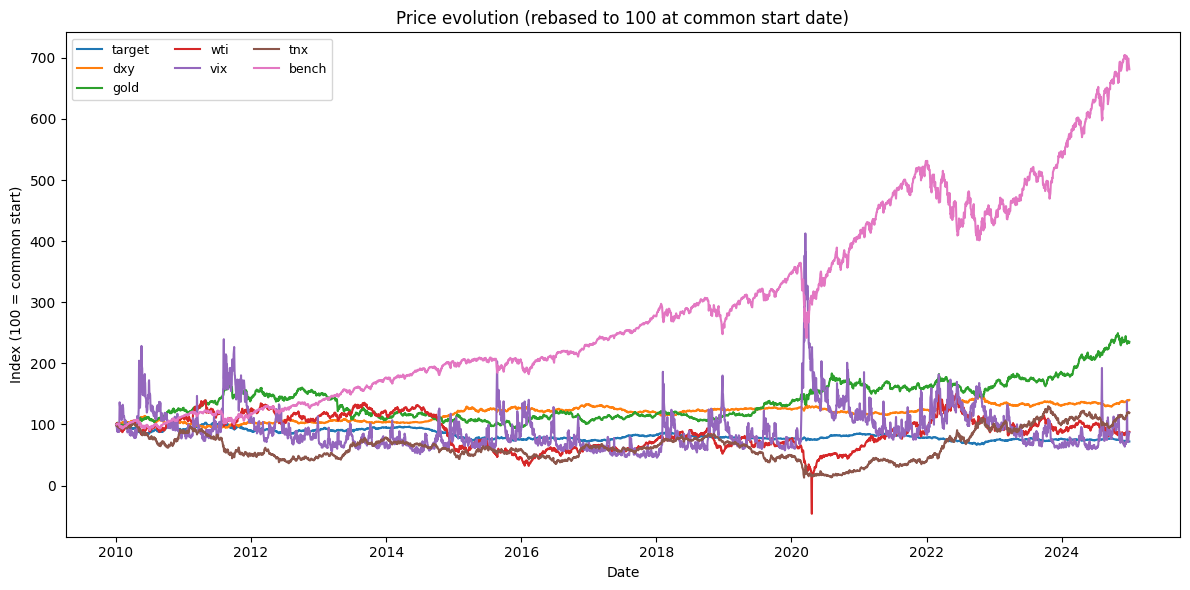

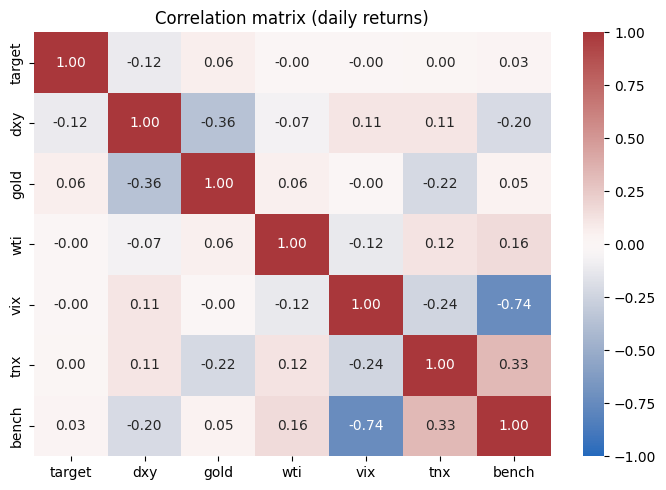

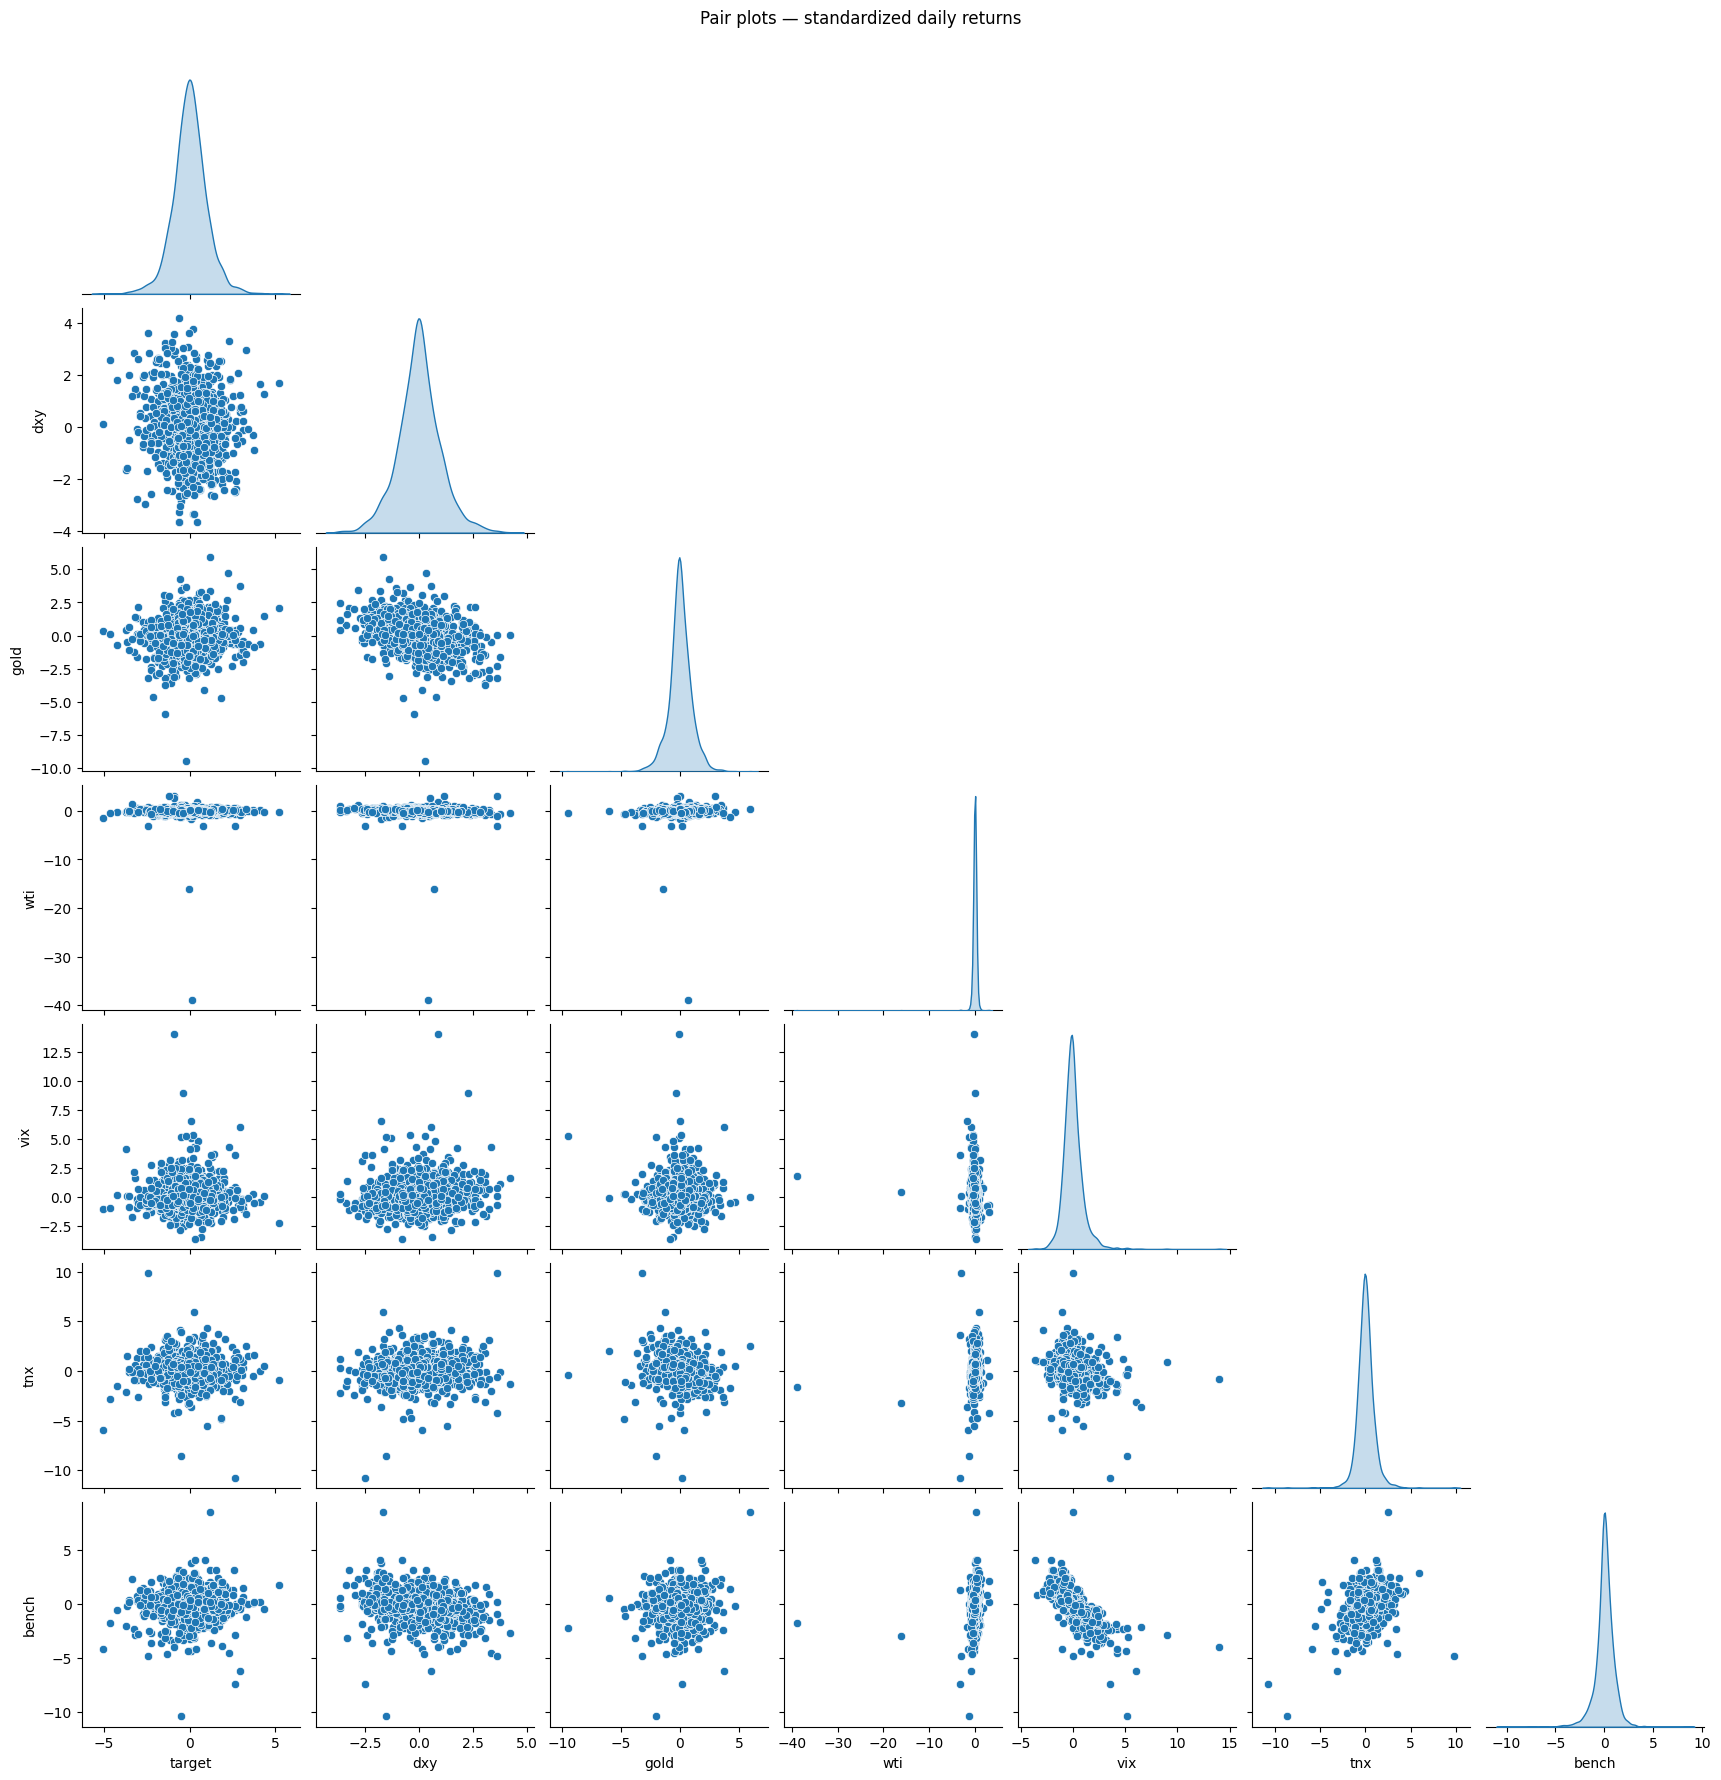

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define close_cols and name_map based on the structure of the 'aligned' DataFrame
close_cols = [col for col in aligned.columns if '_Close' in col]
name_map = {col: col.replace('_Close', '') for col in close_cols}

# Info / describe
display(aligned.info())
display(aligned.describe(include="all").T.head(20))

# Daily returns table
rets_all = aligned[close_cols].pct_change().rename(columns=name_map)

stats_pct = pd.DataFrame({
    "mean_daily_return (%)": rets_all.mean() * 100.0,
    "std_daily_return (%)":  rets_all.std()  * 100.0
}).sort_values("mean_daily_return (%)", ascending=False)

print("Mean and Std of Daily Returns (percentage):")
display(stats_pct.round(2).style.format("{:.2f}"))

# Price evolution (rebased to 100) — all assets
# Common start date (when all assets have data), then rebase
valid_mask = ~aligned[close_cols].isna().any(axis=1)
common_start_idx = valid_mask.idxmax()  # first row where all are non-NaN
prices_cs = aligned.loc[common_start_idx:].reset_index(drop=True)

base_cs = prices_cs[close_cols].iloc[0]
norm_cs  = prices_cs[close_cols].divide(base_cs).multiply(100.0)

plt.figure(figsize=(12,6))
for col in close_cols:
    plt.plot(prices_cs["Date"], norm_cs[col], label=name_map[col])
plt.title("Price evolution (rebased to 100 at common start date)")
plt.xlabel("Date"); plt.ylabel("Index (100 = common start)")
plt.legend(ncol=3, fontsize=9)
plt.tight_layout(); plt.show()

# Correlation matrix (daily returns)
# Ensure 'rets_all' is used for correlation calculation
corr = rets_all.corr()
plt.figure(figsize=(7,5))
sns.heatmap(corr, vmin=-1, vmax=1, annot=True, fmt=".2f", cmap="vlag")
plt.title("Correlation matrix (daily returns)")
plt.tight_layout(); plt.show()

# Pair plots on standardized returns (sampled)
N_SAMPLE = 2000
# Ensure 'rets_all' is used for pairplot
plot_df = rets_all.copy()
if len(plot_df) > N_SAMPLE:
    plot_df = plot_df.sample(N_SAMPLE, random_state=42)
plot_df_std = (plot_df - plot_df.mean()) / (plot_df.std() + 1e-12)

sns.pairplot(plot_df_std, diag_kind="kde", corner=True)
plt.suptitle("Pair plots — standardized daily returns", y=1.02)
plt.show()

## 📊 Pre-Feature Engineering — EDA Summary & Key Takeaways

### **1. Basic Statistics**
- **Highest mean daily return:** `VIX` (+0.30%), but with **very high volatility** (8.12% std) — consistent with its role as a volatility index.
- **Stable assets:** `DXY` and `Gold` show low volatility (<1% std) with small but positive mean returns.
- **Negative average returns:** `WTI` (-0.07%) and `Target` (-0.01%) slightly negative over the sample.
- **Benchmark (likely equity index):** Positive mean return (+0.05%) with moderate volatility (1.06%).

---

### **2. Price Evolution (Rebased to 100)**
- **Benchmark outperformance:** Clear long-term growth, especially post-2016, significantly outperforming other assets.
- **Volatility spikes:** `VIX` shows sharp transient peaks during market stress (e.g., 2020 COVID shock).
- **Commodity trends:** `Gold` exhibits steady appreciation, while `WTI` is more cyclical with deep drawdowns (2014–2016, 2020).

---

### **3. Correlation Structure (Daily Returns)**
- **Strong negative correlation:** `VIX` vs `Benchmark` (-0.74) — aligns with its risk-hedge nature.
- **Moderate negative correlation:** `DXY` vs `Gold` (-0.36), reflecting currency–commodity inverse dynamics.
- **Weak correlations:** Most other pairs are near zero → **diversification potential**.

---

### **4. Pair Plots — Standardized Returns**
- **Return distributions:** Most assets have symmetric, roughly normal daily returns, except `VIX` and `WTI` which show fat tails and extreme outliers.
- **Weak linear relationships:** Scatterplots confirm low correlations from the heatmap; dependencies are modest outside the VIX–Benchmark pair.
- **Potential regime changes:** Outlier clusters in `VIX` and `WTI` may align with crisis periods, useful for **regime detection**.

---

✅ **Implications for Modeling:**
- Low inter-asset correlations suggest **multi-asset features** can bring complementary predictive power.
- VIX & WTI’s extreme events justify **regime-sensitive modeling** (e.g., clustering + regime-specific predictors).
- Benchmark’s clear upward trend vs mixed asset trends makes **feature standardization/normalization essential** to avoid trend bias.
